In [13]:
import os
import glob
import gzip
import math
import random
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LineGraph
import processing_io as pio

districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")
districts_of_interest = [1, 2, 3, 4]

outputs_basecase = pio.get_subdirs("pop_1pm_basecase")
outputs_zone_2 = pio.get_subdirs("pop_1pm_policy_in_zone_1")

In [14]:
random_seed_2_df_basecase = pio.create_dic(subdir=outputs_basecase)
random_seed_2_df_comparison = pio.create_dic(subdir = outputs_zone_2)

In [15]:
geodataframes_basecase = list(random_seed_2_df_basecase.values())
geodataframes_comparison = list(random_seed_2_df_comparison.values())

In [16]:
gdf_basecase_mean = pio.compute_average_or_median_geodataframe(geodataframes=geodataframes_basecase, column_name="vol_car", is_mean=True)
gdf_comparison_mean = pio.compute_average_or_median_geodataframe(geodataframes=geodataframes_comparison, column_name="vol_car", is_mean=True)

In [17]:
gdf_comparison_mean_extended = pio.extend_geodataframe(gdf_base = gdf_basecase_mean, gdf_to_extend=gdf_comparison_mean, column_to_extend='osm:way:highway', new_column_name='highway')
gdf_basecase_mean = gdf_basecase_mean.rename(columns={"osm:way:highway": "highway"})
gdf_basecase_without_unnecessary_columns = pio.remove_columns(gdf_with_correct_columns=gdf_comparison_mean_extended, gdf_to_be_adapted=gdf_basecase_mean)
gdf_basecase_difference = pio.compute_difference_geodataframe(gdf_to_substract_from=gdf_comparison_mean_extended, gdf_to_substract=gdf_basecase_without_unnecessary_columns, column_name= 'vol_car')

In [18]:
# Save the GeoDataFrame to a file
gdf_basecase_mean.to_file("results/gdf_basecase_mean_pop_1pm.geojson", driver='GeoJSON')

/Users/elenanatterer/Development/MATSim/eqasim-java/ile_de_france/src/main/python/process_output_of_simulations/processing_io.py:246: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.001)


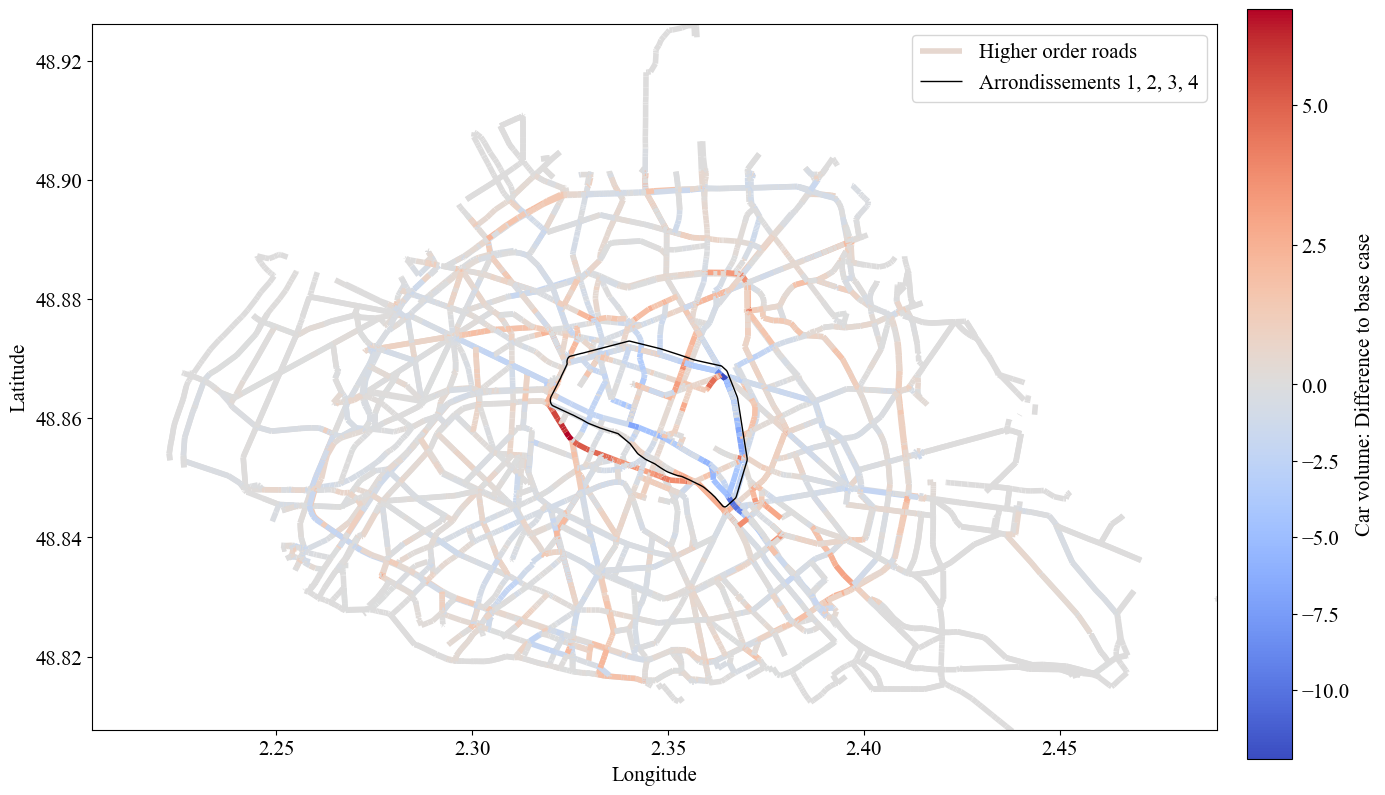

In [19]:
pio.plot_simulation_output(gdf_basecase_difference, districts_of_interest=districts_of_interest)